# A Simple Neural Network - Complete Example


simplified and explained from https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795

In [41]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm


X:  (1797, 8, 8) float64
y:  (1797,) int64
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [0 1 2 3 4]
(1797, 64)
(64, 1203)
(10, 1203)


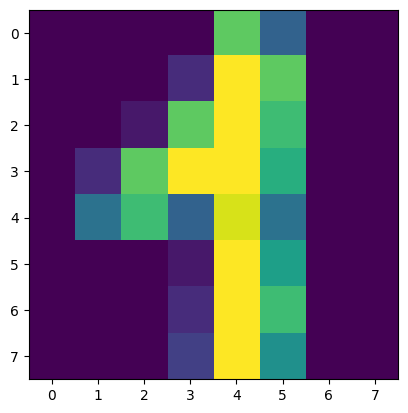

In [42]:
from sklearn import datasets # digits
from sklearn.model_selection import train_test_split
digits = datasets.load_digits()
X = digits.images
y = digits.target
# analyze a bit
print("X: ", X.shape, X.dtype)
print("y: ", y.shape, y.dtype)


plt.imshow(X[42,:,:])


y_onehot=np.zeros(10*y.shape[0]).reshape(-1,10)
for i,yval in enumerate(y):
    y_onehot[i,yval] = 1
print(y_onehot[:5,:], y[:5])
y = y_onehot

X = X.reshape((X.shape[0], -1)) # Flatten X
print(X.shape)  # should be 1797, 64
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


X_train = np.swapaxes(X_train,0,1)
y_train = np.swapaxes(y_train,0,1)
X_test = np.swapaxes(X_test,0,1)
y_test = np.swapaxes(y_test,0,1)

print(X_train.shape)
print(y_train.shape)


In [43]:
nn_architecture = [
    {"input_dim": 64, "output_dim": 49},
    {"input_dim": 49, "output_dim": 10},
]
print(nn_architecture)

[{'input_dim': 64, 'output_dim': 49}, {'input_dim': 49, 'output_dim': 10}]


In [44]:
def init_layers(nn_architecture, seed = 99):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    print("Number of layers: ", number_of_layers)
    params_values = {}

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values
g_param_values = init_layers(nn_architecture)
print("\n".join([x+" of shape " + str(y.shape) for x,y in g_param_values.items()]))

Number of layers:  2
W1 of shape (49, 64)
b1 of shape (49, 1)
W2 of shape (10, 49)
b2 of shape (10, 1)


In [45]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)


# Meaning
- $Z$: Layer values before activation
- $A$: Activation
- $W$: Weight Matrix
- $b$: Bias (can be injected in weight matrix throuhg a column of ones, but here, we don't


$$ Z_{curr} = W_{curr} \cdot A_{prev} + b_{curr} $$
Note that
$$ A_{curr} = \sigma \left( Z_{curr} \right)$$ 
is returned together with $Z$

In [46]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    return sigmoid(Z_curr), Z_curr

# full forward pass just iterates: from X to next layer to next layer...
# memory is handy to understand, but also needed for training (backpropagation)
def full_forward_propagation(X, params_values, nn_architecture):
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr)
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
        
       
    return A_curr, memory
    


In [47]:
# mean squared error    maybe a square root of s would be good, but it does not have meaning.
def get_cost_value(out, Y):
    s =(np.square(out-Y))
    s = np.sum(s)/len(y)   # todo:remove len
    return(s)




# The BackPropagation

Backpropagation is a key algorithm to train deep neural networks. In this algorithm, in a nutshell, 
the gradient of the loss w.r.t. every individual weight value (in whichever layer) is computed.

Technically, this is done through a recursive process which depends on values from the previous layer. So it 
propagates layer by layer. 

First, we define how to go one layer backwards. The arguments:
- `dA_curr`: The current deviation, starts with error and is output of the step as `dA_prev`
- `W_curr, b_curr`: the weights and biases are known
- `Z_curr`: the value of the forward pass *before* activation (known as we track it in memory)
- `A_prev`: the activation of the previous layer (known as tracked)

In [49]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev):
    m = A_prev.shape[1]
    
    dZ_curr = sigmoid_backward(dA_curr, Z_curr)      
    dW_curr = np.dot(dZ_curr, A_prev.T) / m          
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

In [50]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)
   
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

In [ ]:
def update(params_values, grads_values, nn_architecture, learning_rate):
    for layer_idx, layer in enumerate(nn_architecture):
        layer_idx = layer_idx +1
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

In [52]:
def get_accuracy_value(a,b):
    an = np.argmax(a, axis=0)
    bn = np.argmax(b,axis=0)
    return np.sum(an == bn) / len(an)

def train(X, Y, nn_architecture, epochs, learning_rate, params_values=None):
    if params_values is None:
        params_values = init_layers(nn_architecture, 42)
    cost_history = []
    accuracy_history = []
    
    for i in tqdm(range(epochs)):
        Y_hat, cache = full_forward_propagation(X, params_values, nn_architecture)
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat,Y)#get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        grads_values = full_backward_propagation(Y_hat, Y, cache, params_values, nn_architecture)
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
    return params_values, cost_history, accuracy_history

Performing Mega-Step of 10 epochs training with full testset prediction
Number of layers:  2


  0%|          | 0/100 [00:00<?, ?it/s]

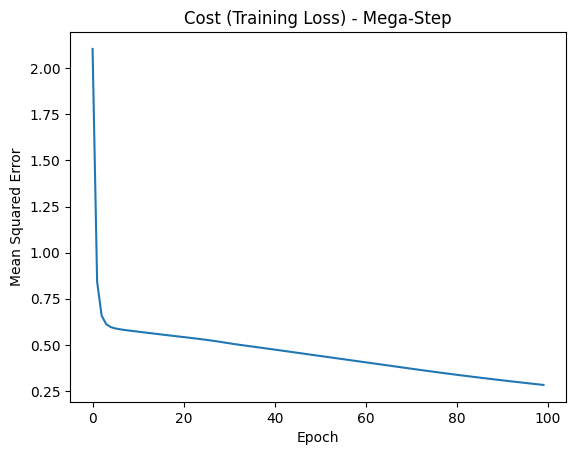

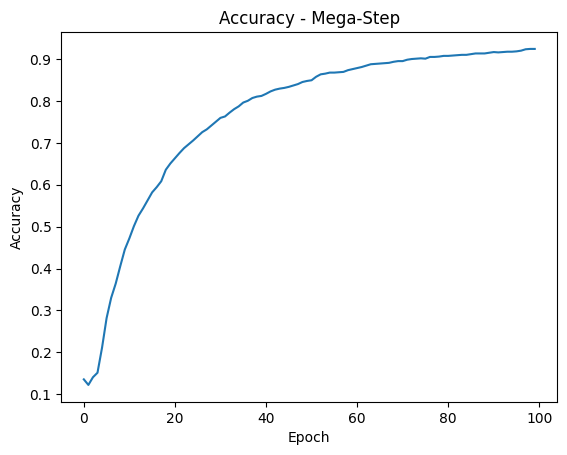

Validation Accuracy: 0.917508
Training Accuracy: 0.925187
Performing Mega-Step of 10 epochs training with full testset prediction


  0%|          | 0/100 [00:00<?, ?it/s]

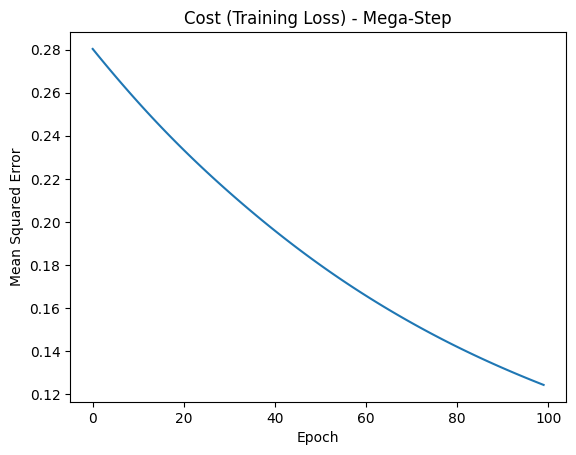

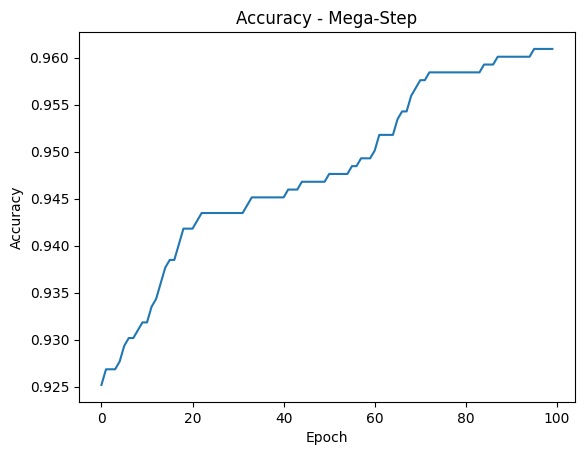

Validation Accuracy: 0.949495
Training Accuracy: 0.960931
Performing Mega-Step of 10 epochs training with full testset prediction


  0%|          | 0/100 [00:00<?, ?it/s]

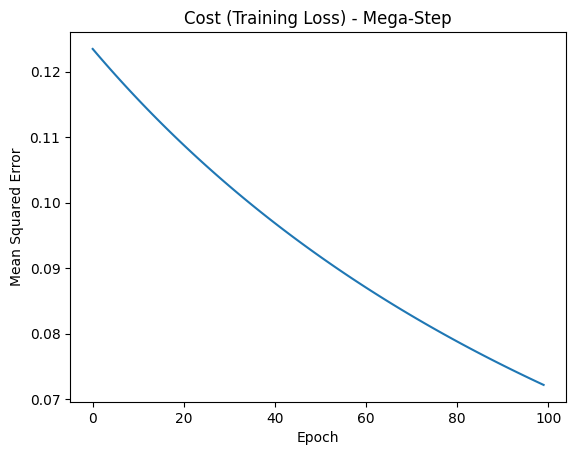

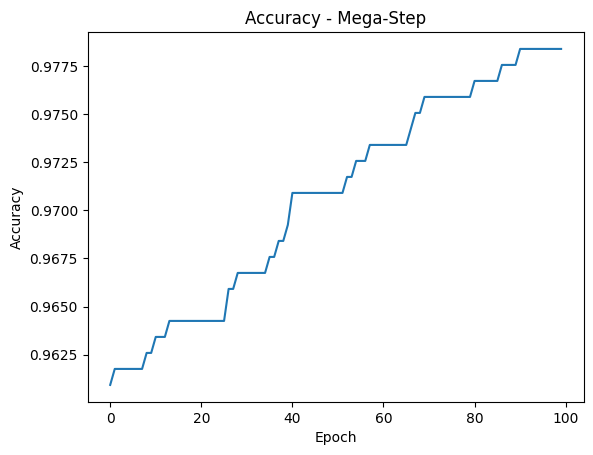

Validation Accuracy: 0.966330
Training Accuracy: 0.978387
Performing Mega-Step of 10 epochs training with full testset prediction


  0%|          | 0/100 [00:00<?, ?it/s]

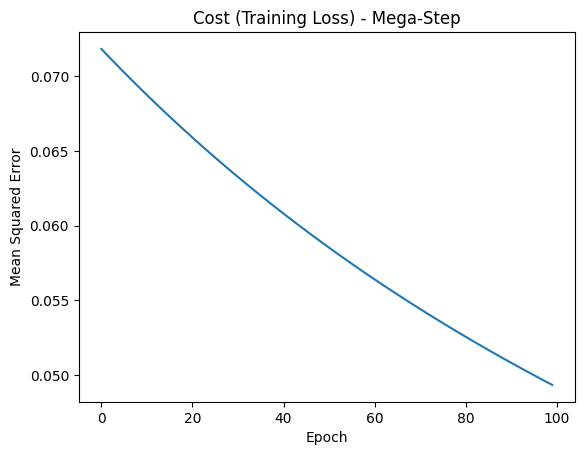

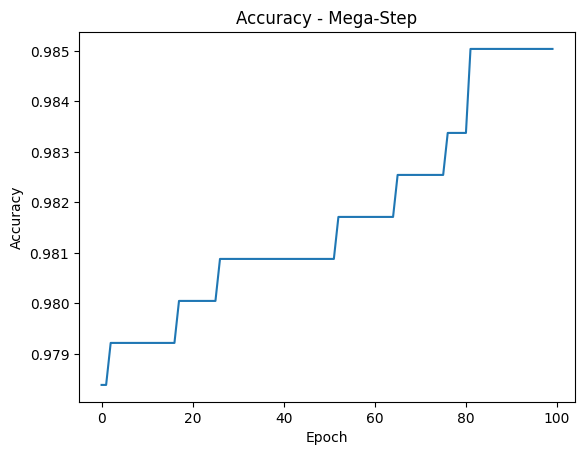

Validation Accuracy: 0.971380
Training Accuracy: 0.985037
Performing Mega-Step of 10 epochs training with full testset prediction


  0%|          | 0/100 [00:00<?, ?it/s]

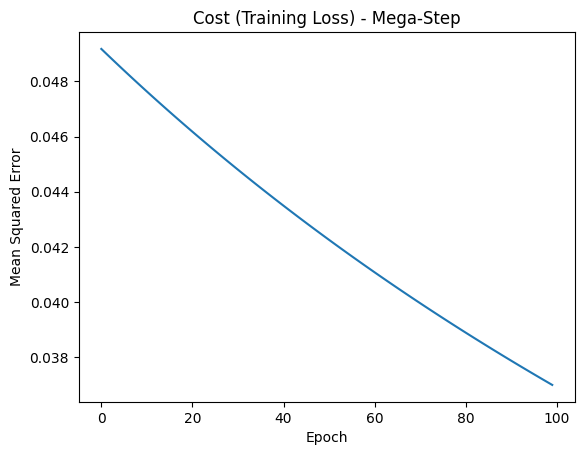

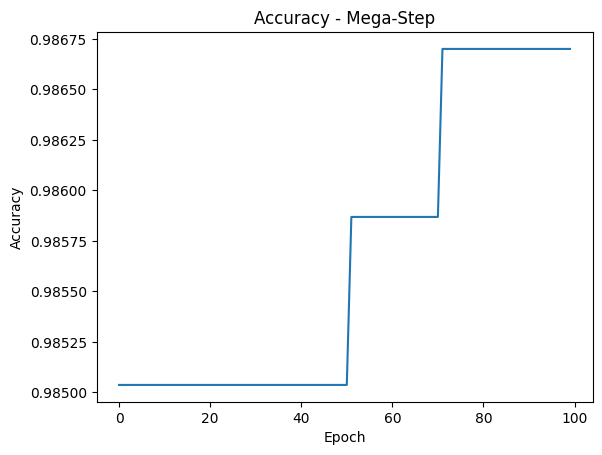

Validation Accuracy: 0.973064
Training Accuracy: 0.986700
Performing Mega-Step of 10 epochs training with full testset prediction


  0%|          | 0/100 [00:00<?, ?it/s]

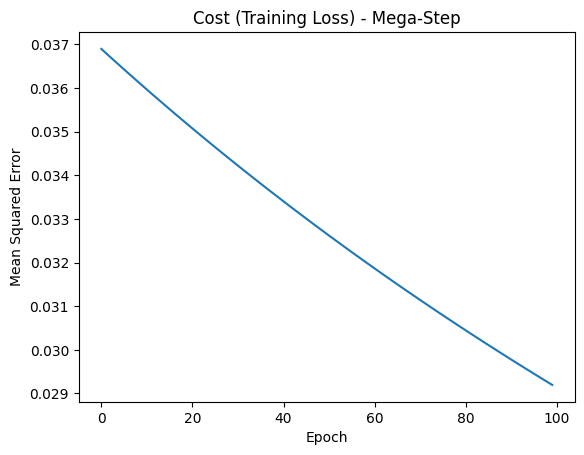

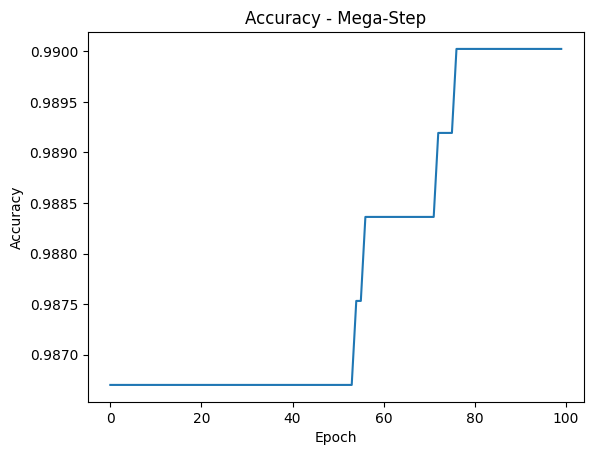

Validation Accuracy: 0.973064
Training Accuracy: 0.990025
Performing Mega-Step of 10 epochs training with full testset prediction


  0%|          | 0/100 [00:00<?, ?it/s]

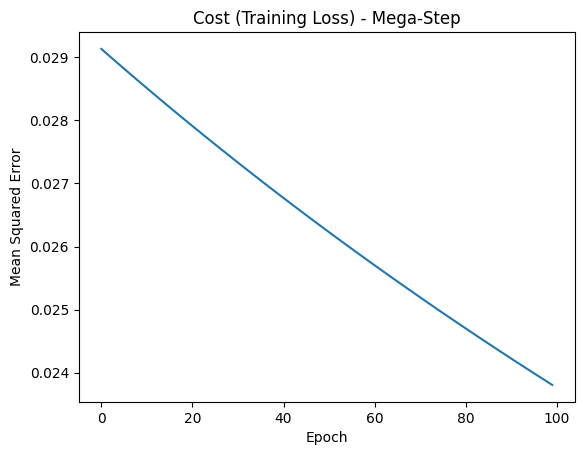

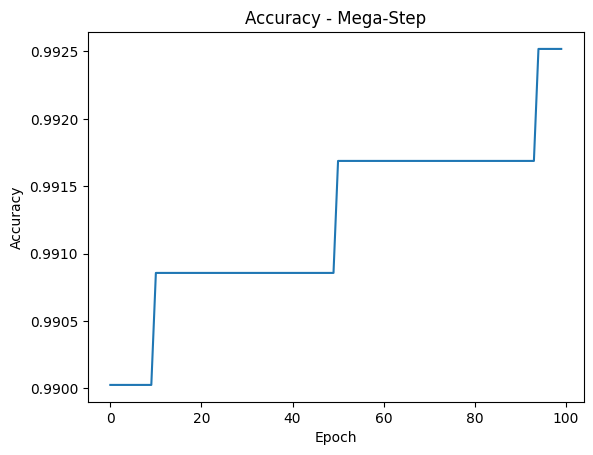

Validation Accuracy: 0.974747
Training Accuracy: 0.992519
Performing Mega-Step of 10 epochs training with full testset prediction


  0%|          | 0/100 [00:00<?, ?it/s]

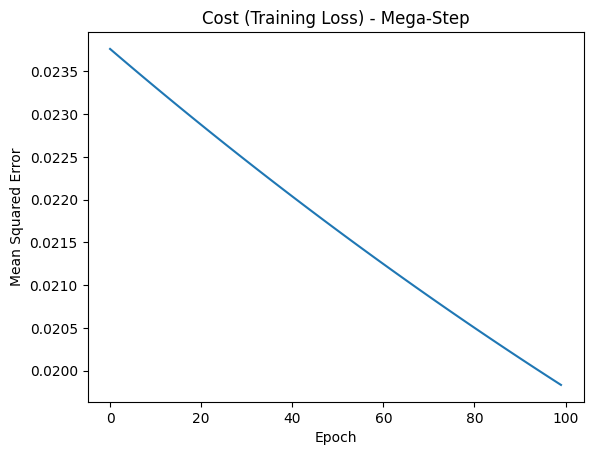

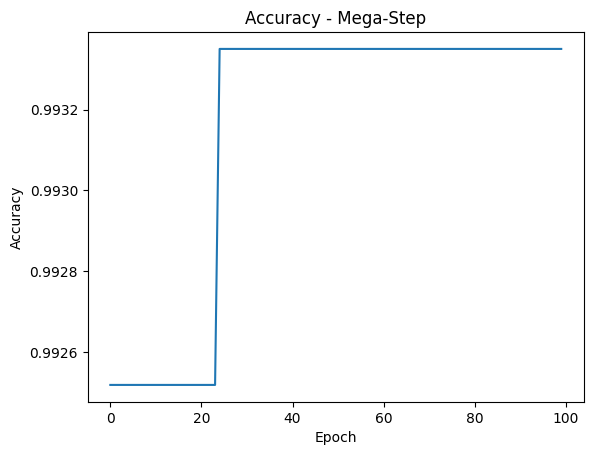

Validation Accuracy: 0.974747
Training Accuracy: 0.993350
Performing Mega-Step of 10 epochs training with full testset prediction


  0%|          | 0/100 [00:00<?, ?it/s]

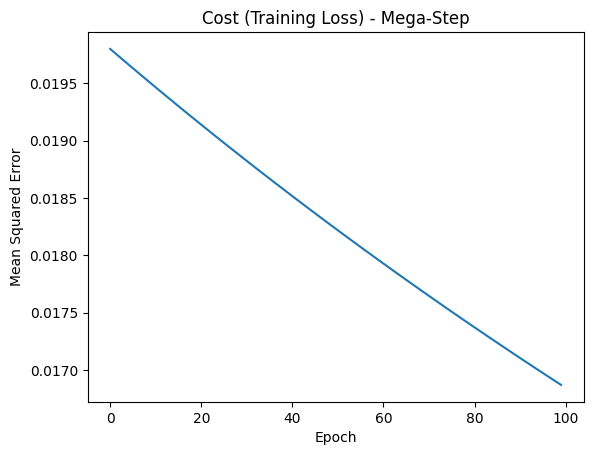

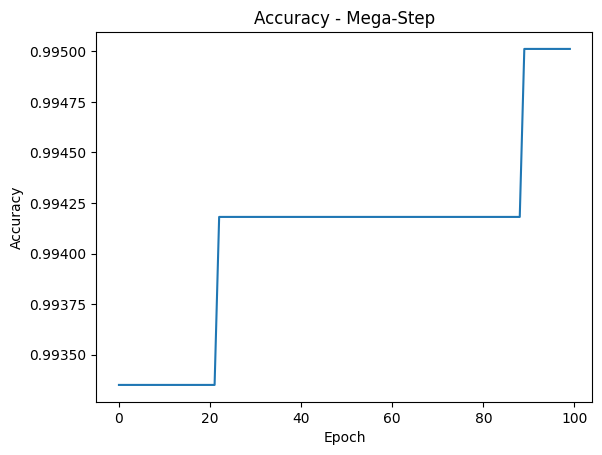

Validation Accuracy: 0.974747
Training Accuracy: 0.995012
Performing Mega-Step of 10 epochs training with full testset prediction


  0%|          | 0/100 [00:00<?, ?it/s]

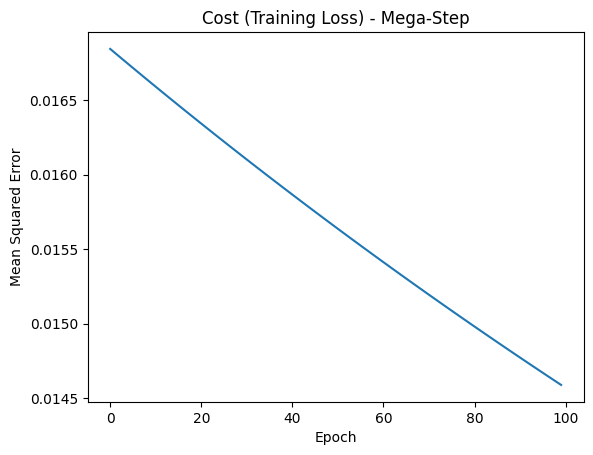

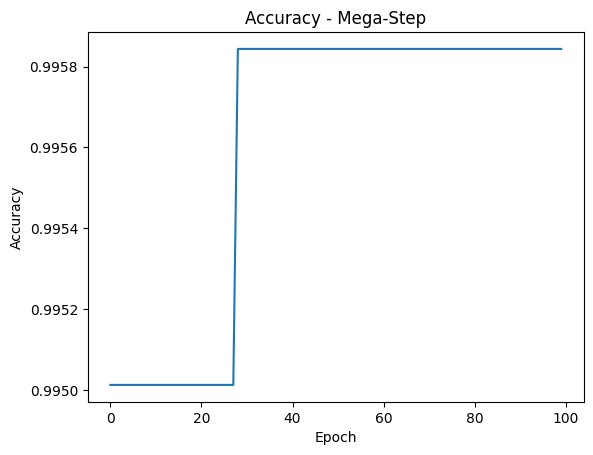

Validation Accuracy: 0.974747
Training Accuracy: 0.995844


In [53]:
params_values = None # start out unitinializted

for _ in range(10):
    print("Performing Mega-Step of 10 epochs training with full testset prediction")
    params_values, cost_history, accuracy_history = train(X_train,y_train,nn_architecture,100,0.1, params_values)
    plt.plot(cost_history)
    plt.title('Cost (Training Loss) - Mega-Step')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.show()
    plt.plot(accuracy_history)
    plt.title('Accuracy - Mega-Step')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    # validation
    prediction,_ = full_forward_propagation(X_test,params_values,nn_architecture)
    tprediction,_ = full_forward_propagation(X_train,params_values,nn_architecture)
    print("Validation Accuracy: %f" % (get_accuracy_value(y_test,prediction)))
    print("Training Accuracy: %f" % (get_accuracy_value(y_train,tprediction)))





#

# Real Training
We got about 98 %. Let us do a real training now

Number of layers:  2


  0%|          | 0/20000 [00:00<?, ?it/s]

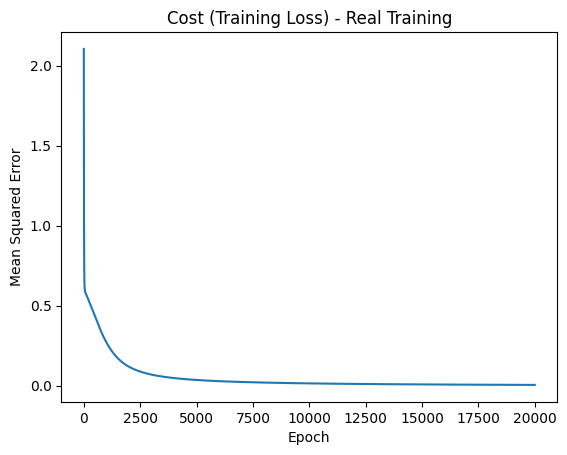

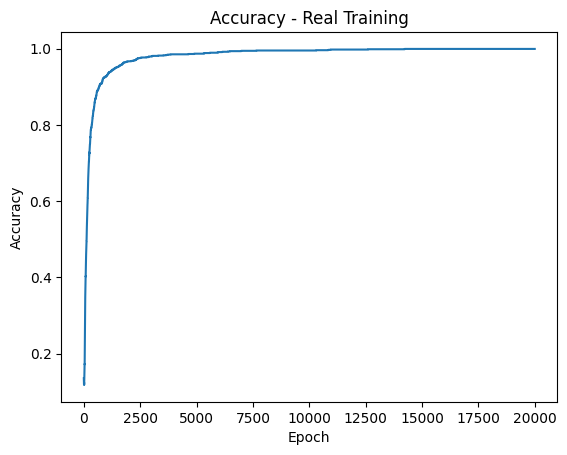

Training Accuracy: 0.999169
Validation Accuracy: 0.979798


In [55]:
params_values, cost_history, accuracy_history = train(X_train,y_train,nn_architecture,20000,0.01)
plt.plot(cost_history)
plt.title('Cost (Training Loss) - Real Training')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.show()
plt.plot(accuracy_history)
plt.title('Accuracy - Real Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
prediction,_ = full_forward_propagation(X_test,params_values,nn_architecture)
tprediction,_ = full_forward_propagation(X_train,params_values,nn_architecture)

print("Training Accuracy: %f" % (get_accuracy_value(y_train,tprediction)))
print("Validation Accuracy: %f" % (get_accuracy_value(y_test,prediction)))



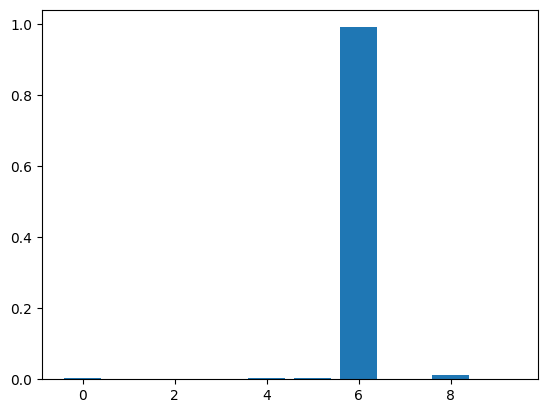

(64,)


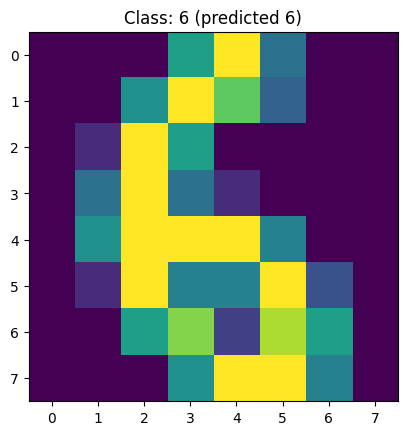

In [61]:
# Now let us predict an example
choice = np.random.choice(range(X_test.shape[1]))
example = X_test[:,choice]

#def full_forward_propagation(X, params_values, nn_architecture):
prediction,_ = full_forward_propagation(example.reshape(64,1),params_values,nn_architecture)
prediction = prediction.flatten()
plt.bar(range(len(prediction)), prediction)
prediction = np.argmax(prediction)
plt.show()
print(example.shape)
plt.imshow(example.reshape(8,8))
plt.title("Class: %d (predicted %d)"% (np.argmax(y_test[:,choice]), prediction))
plt.show()

# Searching for the Right Architecture

It is pretty hard to find the parameters of an architecture giving success on a dataset. Let us illustrate this 
problem on our toy dataset. Let us assume a very reasonable application in an embedded device given as a
requirement as follows: Deploy the smallest neural network that brings 95% accuracy on the test set with a training 
in 500 epochs with a standard LR of 0.01

Disclaimer: As we use the validation set to find parameters, we would need another holdout set (test set) for final
performance estimation. We skip this detail here. Note that our predicted performance is optimistic. Real world would be worse

In [ ]:
# We like powers of two, so let us stay with them
test_accuracy = 0
runs = 0
best_architecture={}
while runs < 10:
    hidden = int(np.random.uniform(4,64))
    # set up architecture
    nn_architecture = [
    {"input_dim": 64, "output_dim": hidden},
    {"input_dim": hidden, "output_dim": 10},
    ]
    print("Training %d hidden units" % (hidden))
    params_values, cost_history, accuracy_history = train(X_train,y_train,nn_architecture,10000,0.01)
    prediction,_ = full_forward_propagation(X_test,params_values,nn_architecture)
    tprediction,_ = full_forward_propagation(X_train,params_values,nn_architecture)
    test_accuracy = get_accuracy_value(y_test,prediction)
    print("Training Accuracy: %f" % (get_accuracy_value(y_train,tprediction)))
    print("Test Accuracy (here it is more validation accuracy, but we chose the names): %f" % (test_accuracy))
    if "accuracy" not in best_architecture:
        best_architecture["accuracy"] = test_accuracy
        best_architecture["hidden"] = hidden
    
    if (test_accuracy > best_architecture["accuracy"]):
        best_architecture["accuracy"] = test_accuracy
        best_architecture["hidden"] = hidden
        
    print(best_architecture)
        
    runs = runs+1


Training 36 hidden units
Number of layers:  3


  0%|          | 0/10000 [00:00<?, ?it/s]

Training Accuracy: 0.964256
Test Accuracy (here it is more validation accuracy, but we chose the names): 0.930976
{'accuracy': np.float64(0.930976430976431), 'hidden': 36}
Training 50 hidden units
Number of layers:  3


  0%|          | 0/10000 [00:00<?, ?it/s]

Training Accuracy: 0.985869
Test Accuracy (here it is more validation accuracy, but we chose the names): 0.959596
{'accuracy': np.float64(0.9595959595959596), 'hidden': 50}
Training 11 hidden units
Number of layers:  3


  0%|          | 0/10000 [00:00<?, ?it/s]

Training Accuracy: 0.111388
Test Accuracy (here it is more validation accuracy, but we chose the names): 0.104377
{'accuracy': np.float64(0.9595959595959596), 'hidden': 50}
Training 24 hidden units
Number of layers:  3


  0%|          | 0/10000 [00:00<?, ?it/s]

Training Accuracy: 0.789692
Test Accuracy (here it is more validation accuracy, but we chose the names): 0.760943
{'accuracy': np.float64(0.9595959595959596), 'hidden': 50}
Training 33 hidden units
Number of layers:  3


  0%|          | 0/10000 [00:00<?, ?it/s]

Training Accuracy: 0.967581
Test Accuracy (here it is more validation accuracy, but we chose the names): 0.937710
{'accuracy': np.float64(0.9595959595959596), 'hidden': 50}
Training 12 hidden units
Number of layers:  3


  0%|          | 0/10000 [00:00<?, ?it/s]

Training Accuracy: 0.106401
Test Accuracy (here it is more validation accuracy, but we chose the names): 0.095960
{'accuracy': np.float64(0.9595959595959596), 'hidden': 50}
Training 31 hidden units
Number of layers:  3


  0%|          | 0/10000 [00:00<?, ?it/s]

Training Accuracy: 0.965919
Test Accuracy (here it is more validation accuracy, but we chose the names): 0.927609
{'accuracy': np.float64(0.9595959595959596), 'hidden': 50}
Training 53 hidden units
Number of layers:  3


  0%|          | 0/10000 [00:00<?, ?it/s]

Training Accuracy: 0.991687
Test Accuracy (here it is more validation accuracy, but we chose the names): 0.969697
{'accuracy': np.float64(0.9696969696969697), 'hidden': 53}
Training 13 hidden units
Number of layers:  3


  0%|          | 0/10000 [00:00<?, ?it/s]

Training Accuracy: 0.105569
Test Accuracy (here it is more validation accuracy, but we chose the names): 0.094276
{'accuracy': np.float64(0.9696969696969697), 'hidden': 53}
Training 51 hidden units
Number of layers:  3


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 